In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import torch.utils.data as data
import seaborn as sns

# SciKit
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Python
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import time

In [2]:
# load dataset
input_data = pd.read_csv('station/466920taipei.csv', usecols = ["觀測時間(hour)", "測站氣壓(hPa)", "海平面氣壓(hPa)", "氣溫(℃)", "露點溫度(℃)", "相對溼度(%)", "風速(m/s)", "降水量(mm)", "降水時數(hr)", "日照時數(hr)", "天全空日射量(MJ/㎡)"])

# fill NaN with 0
input_data = input_data.fillna(0)

input_data['觀測時間(hour)'] = pd.to_datetime(input_data['觀測時間(hour)'])
input_data.set_index('觀測時間(hour)')

input_data.head()

,觀測時間(hour),測站氣壓(hPa),海平面氣壓(hPa),氣溫(℃),露點溫度(℃),相對溼度(%),風速(m/s),降水量(mm),降水時數(hr),日照時數(hr),天全空日射量(MJ/㎡)
0,2010-01-01 00:00:00,1021.8,1022.6,13.7,8.2,69.0,3.6,0.0,0.0,0.0,0.0
1,2010-01-01 01:00:00,1021.4,1022.2,13.8,8.3,69.0,4.0,0.0,0.0,0.0,0.0
2,2010-01-01 02:00:00,1020.4,1021.2,13.9,8.4,69.0,3.8,0.0,0.0,0.0,0.0
3,2010-01-01 03:00:00,1019.9,1020.7,13.9,8.4,69.0,4.1,0.0,0.0,0.0,0.0
4,2010-01-01 04:00:00,1019.6,1020.4,14.0,8.5,69.0,3.3,0.0,0.0,0.0,0.0


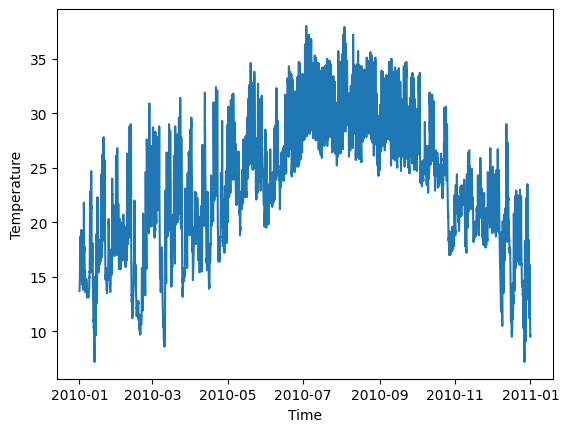

In [3]:
# 選擇 2010 年的資料
input_data_2010 = input_data[input_data['觀測時間(hour)'].dt.year == 2010]

plt.plot(input_data_2010['觀測時間(hour)'], input_data_2010['氣溫(℃)'])
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.show()

In [5]:
train_len = int(0.7*len(input_data))
valid_len = len(input_data) - train_len

train_data, valid_data = random_split(input_data,[train_len, valid_len])

# Feature Selection